In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1, 2"
os.environ["NCCL_DEBUG"]="WARN"
#os.environ["NCCL_P2P_LEVEL"]="NODE"

In [2]:
import sys
sys.path.append("../../../")

In [3]:
%load_ext autoreload
%autoreload 2

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [4]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.model.vqgan_clean.vqgan import VQGAN
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
import tensorflow as tf
from datetime import datetime
from tqdm import tqdm
import os
from pyprojroot.pyprojroot import here
#tf.get_logger().setLevel('ERROR')

In [5]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [6]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2022-07-20 04:10:04.882727: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 04:10:05.601923: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22297 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:25:00.0, compute capability: 8.6
2022-07-20 04:10:05.602936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22297 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6


In [7]:
cfg = omegaconf.OmegaConf.load(here("configs/kny_image_style.yaml"))

In [8]:
num_workers = len(tf.config.list_physical_devices("GPU"))
batch_size = cfg["trainer"]["batch_size"] 
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = cfg["trainer"]["n_epochs"] 
sample_batch_size = 8

In [9]:
dataset_length = 34045 # KNY
#dataset_length = 20*10000 # MNIST
num_batch = dataset_length / batch_size

In [10]:
def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], 3))
    element = tf.cast(element, tf.float32) / 255.0
    return element, element

In [11]:
dataset = ImageDataset("../../../data/kny/images_tfrecords_light").load()
dataset = dataset.shuffle(dataset_length, reshuffle_each_iteration=True, seed=10).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
train_size = int(dataset_length * 0.2)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [13]:
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

In [14]:
train_sample_data = next(train_ds
                          .batch(sample_batch_size)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.batch(sample_batch_size).as_numpy_iterator())

In [15]:
train_ds = (train_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.batch(global_batch_size, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

In [16]:
from ganime.utils.callbacks import TensorboardImage, get_logdir

logdir = "../../../logs/ganime/vqgan/style_loss_2022-07-19_10-58-57" #get_logdir("../../../logs/ganime/vqgan", experiment_name="style_loss")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_image_callback = TensorboardImage(logdir, train_sample_data, validation_sample_data)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_total_loss",
    min_delta=0.0001,
    patience=100,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_total_loss', save_best_only=True, save_weights_only=True)
callbacks = [tensorboard_callback, tensorboard_image_callback, checkpointing]

In [17]:
# train_mean, train_var, train_std = dataset_statistics(train_ds)

In [18]:
from ganime.visualization.images import display_true_pred

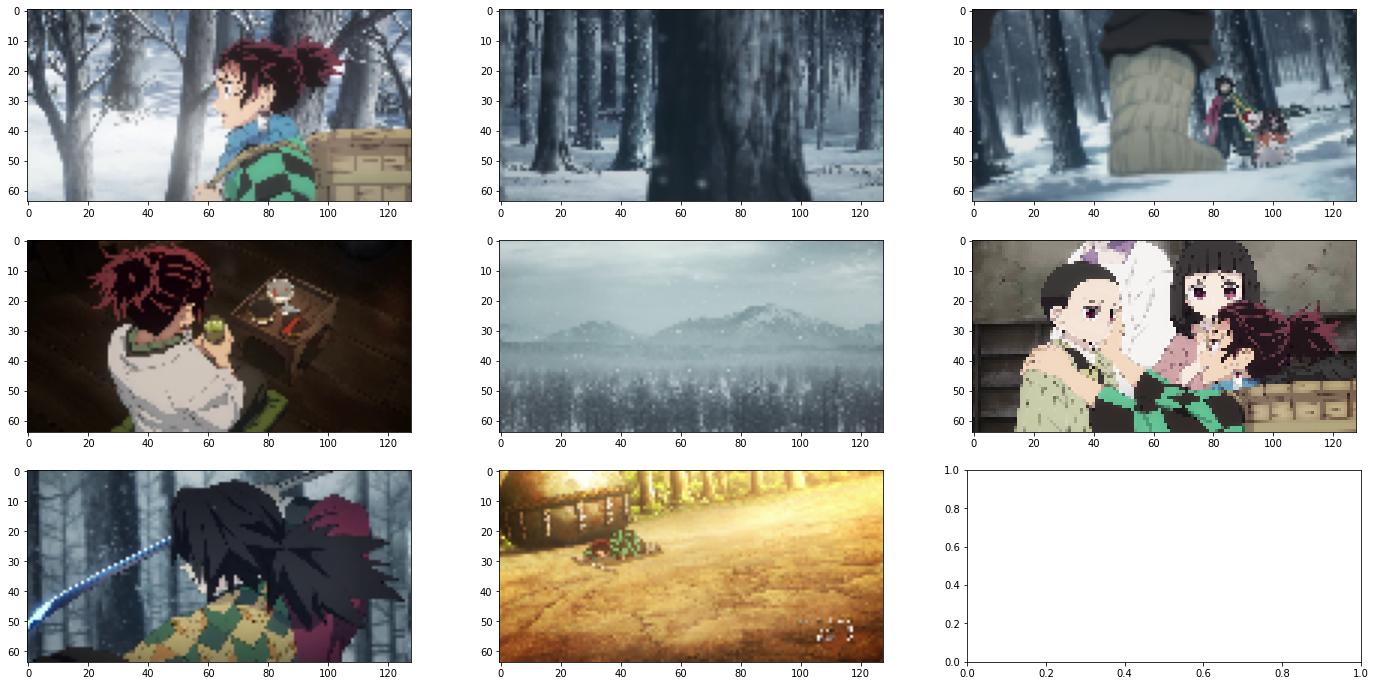

In [19]:
display_images(train_sample_data[0])
plt.show()

In [20]:
with strategy.scope():
    vqgan = VQGAN(**cfg["model"])

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica

In [21]:
with strategy.scope():
    gen_optimizer = tf.keras.optimizers.Adam(
                learning_rate=cfg["trainer"]["gen_lr"],
                beta_1=cfg["trainer"]["gen_beta_1"],
                beta_2=cfg["trainer"]["gen_beta_2"],
                clipnorm=cfg["trainer"]["gen_clip_norm"],
    )
    disc_optimizer = tf.keras.optimizers.Adam(
        learning_rate=cfg["trainer"]["disc_lr"],
        beta_1=cfg["trainer"]["disc_beta_1"],
        beta_2=cfg["trainer"]["disc_beta_2"],
        clipnorm=cfg["trainer"]["disc_clip_norm"],
    )
    vqgan.compile(gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer)

In [ ]:
history = vqgan.fit(train_ds, validation_data=validation_ds, initial_epoch=183, epochs=n_epochs, callbacks=callbacks)

Epoch 184/2000
INFO:tensorflow:batch_all_reduce: 155 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 155 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = hierarchical_copy, num_packs = 1


2022-07-20 04:11:26.665432: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-07-20 04:11:27.490574: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-07-20 04:11:29.266609: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


106/106 [==============================] - 193s 1s/step - total_loss: 0.0254 - reconstruction_loss: 0.0022 - vq_loss: 0.0186 - disc_loss: 0.0000e+00 - val_total_loss: 0.0216 - val_reconstruction_loss: 0.0025 - val_vq_loss: 0.0192 - val_disc_loss: 0.0000e+00
Epoch 185/2000
106/106 [==============================] - 92s 861ms/step - total_loss: 0.0297 - reconstruction_loss: 0.0024 - vq_loss: 0.0203 - disc_loss: 0.0000e+00 - val_total_loss: 0.0220 - val_reconstruction_loss: 0.0021 - val_vq_loss: 0.0199 - val_disc_loss: 0.0000e+00
Epoch 186/2000
106/106 [==============================] - 95s 882ms/step - total_loss: 0.0286 - reconstruction_loss: 0.0023 - vq_loss: 0.0195 - disc_loss: 0.0000e+00 - val_total_loss: 0.0236 - val_reconstruction_loss: 0.0022 - val_vq_loss: 0.0213 - val_disc_loss: 0.0000e+00
Epoch 187/2000
106/106 [==============================] - 92s 858ms/step - total_loss: 0.0298 - reconstruction_loss: 0.0022 - vq_loss: 0.0210 - disc_loss: 0.0000e+00 - val_total_loss: 0.0212 -

In [ ]:
with strategy.scope():
    x = train_sample_data[0]
    generated = vqgan(x[:10])[0]

In [ ]:
vqgan.summary()

In [ ]:
from ganime.model.vqgan_clean.losses.losses import Losses
from ganime.model.vqgan_clean.losses.vqperceptual import PerceptualLoss

In [ ]:
losses = Losses(1)

In [ ]:
real = x
pred = generated

In [ ]:
losses.perceptual_loss(real.copy(), pred)

In [ ]:
losses.vgg_loss(real, pred)

In [ ]:
losses.style_loss(real, pred)

In [ ]:
PerceptualLoss()(real, pred)

In [ ]:
display_images(pred)
plt.show()

In [ ]:
display_images(real)
plt.show()